This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [20]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [21]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1f62a9a9d80>)

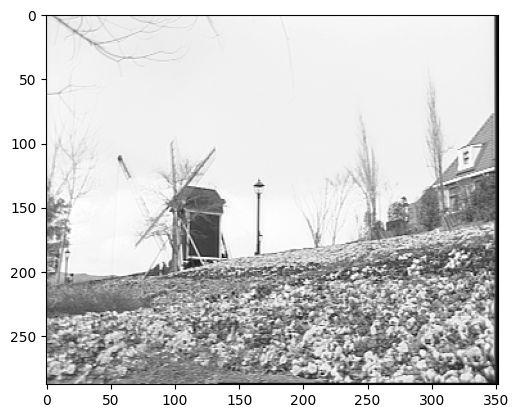

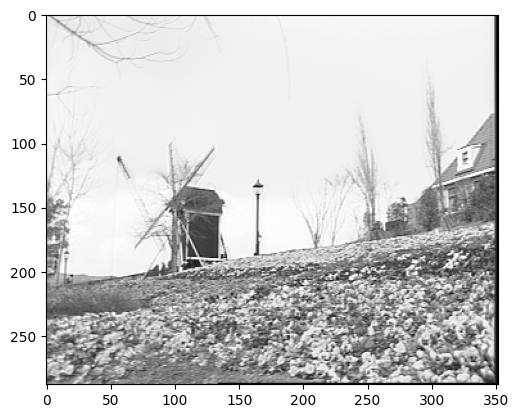

In [22]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [23]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [44]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection

                B = cur[r:r+brow,c:c+bcol] # Block

                # Initialization:
                
                costMin = float('inf')
                
                Rbest = np.zeros(B.shape)
                best_drow, best_dcol = 0, 0
                # Loop on candidate displacement vectors
                for dcol in range(-search, search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search+1):
                        
                        Bref = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]
                        
                        SSD_cost = np.sum((B - Bref)**2)
                        
                        if SSD_cost  < costMin:
                            R_best = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SSD_cost# Save the results if they are better than the previous ones
                            
                            
                mvf[i:i+brow, j:j+bcol, 0] = i-best_drow # Once the loop is over, save the best row displacement field
                mvf[i:i+brow, j:j+bcol, 1] = j-best_dcol# Once the loop is over, save the best column displacement field
                prediction[i:i+brow,j:j+bcol]= Rbest
                
    else: # Regularized search
       for i in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]# Block

                # Initializations          
                costMin = float('inf')
                
                Rbest = np.zeros(B.shape)
                best_drow, best_dcol = 0, 0
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(i,j,brow,bcol,mvf,ref,cur)
                
                #Loop on candidate displacement vectors
                for dcol in range(i-search, i+search, 1): # dcol = candidate displacement vector over the columns
                    for drow in range(j-search, j+search, 1):
                        
                        Bref = ref_extended[drow+search:drow+brow+search,dcol+search:dcol+bcol+search]
                        print(np.array([drow, dcol]).shape)
                        
                        SSD_cost = np.sum((B - Bref)**2) + lamb*np.linalg.norm(np.array([drow, dcol]) - pV) 
                        
                        if SSD_cost  < costMin:
                            R_best = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SSD_cost# Save the results if they are better than the previous ones
                            
                            
                mvf[i:i+brow,j:j+bcol,0]= i-best_drow # Once the loop is over, save the best row displacement field
                mvf[j:j+brow,j:j+bcol,1]= j-best_dcol # Once the loop is over, save the best column displacement field
                prediction[i:i+brow,j:j+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : Motion Vector Field. Contains a motion vector for each pixel of the image
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)  # To avoid border effect

    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol

    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))

    # Non-regularized search
    if lamb == 0.:
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+bcol]  # Block #####

                # Initialization:
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                best_drow, best_dcol = 0, 0

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns #####
                for dcol in range(-search, search+1):
                    for drow in range(-search, search+1):

                        temp_block = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]

                        temp_cost = np.sum((B - temp_block)**2)

                        if temp_cost < costMin:  # Save the results if they are better than the previous ones
                            costMin = temp_cost
                            Rbest = temp_block
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest

    else: # Regularized search
        print('Regularization')
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+bcol]  # Block #####

                # Initialization:
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                best_drow, best_dcol = 0, 0

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns #####
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                for dcol in range(-search, search+1):
                    for drow in range(-search, search+1):

                        temp_block = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]

                        temp_cost = np.sum((B - temp_block)**2) + lamb * np.sum(([drow, dcol] - pV) ** 2)

                        if temp_cost < costMin:  # Save the results if they are better than the previous ones
                            costMin = temp_cost
                            Rbest = temp_block
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest

    mvf = -mvf  # For compatibility with standards

    return mvf, prediction





In [51]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius,lamb = 2.0)

Regularization


Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

It seems that there are errors in the sky, that should not change on time. This happens because the algorithm finds really similar values in the sky in different positions, once the sky has an uniform intensity. As we don't have any penalization  in cost for choosing a the best block that can have similar intensity but far away from the reference block. 

Below, we can see the difference of addinga regularization term.

In [49]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

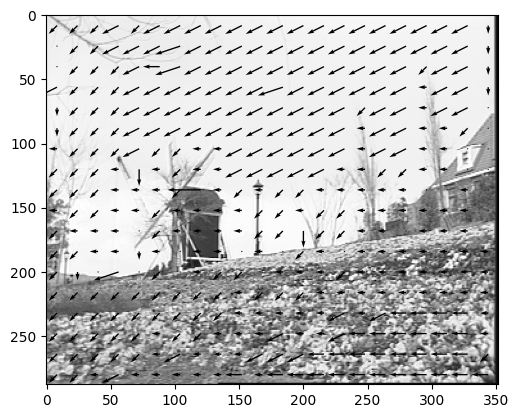

In [52]:
displayMVF(im2,mvf_ssd,brow)

Change the block size and the search area radius. How does it impact your results?

If we decrease too much the block size, we start to see more details, and of course, more noise. We can check that the number of vector with the error in sky descreases, but the ones that remains became much bigger, as expected. Using the regularization term, we can check that the effect of the seracg area radius does not affect that much the result.

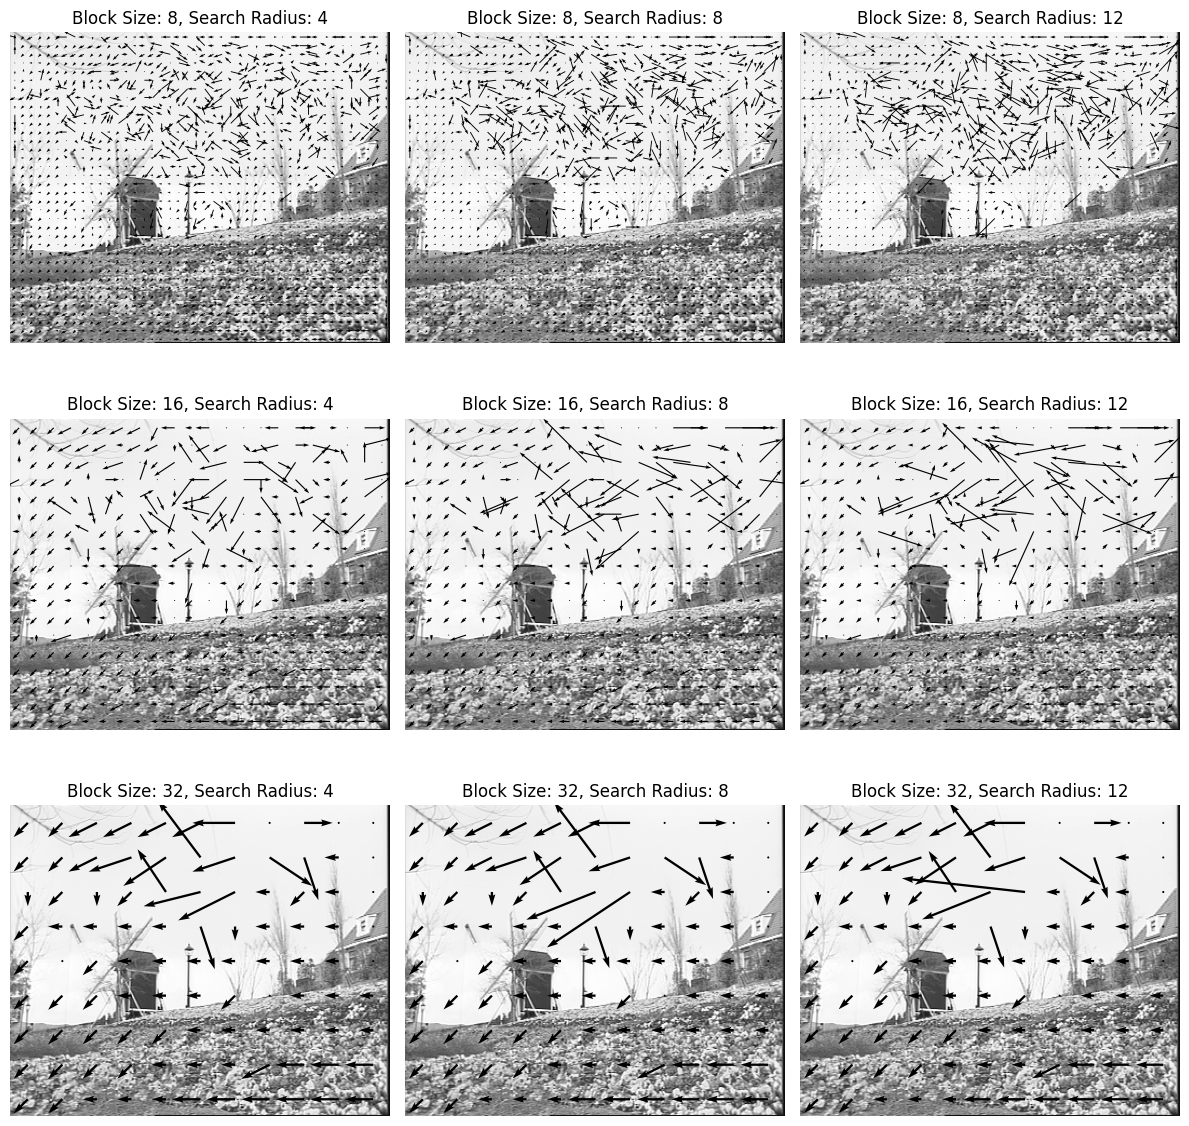

In [55]:
block_sizes = [8, 16, 32]  # List of block sizes to iterate over
search_radii = [4, 8, 12]  # List of search radii to iterate over

fig, axs = plt.subplots(len(block_sizes), len(search_radii), figsize=(12, 12))

row,col = np.shape(im1)
for i, block_size in enumerate(block_sizes):
	for j, search_radius in enumerate(search_radii):
		mvf, prediction = me_ssd(im2, im1, block_size, block_size, search_radius)
		subsamp = 4  # Subsampling factor for dense MVF display

		vectRow = mvf[0:row:block_size, 0:col:block_size, 0]
		vectCol = mvf[0:row:block_size, 0:col:block_size, 1]

		# Determine vector origins
		X, Y = np.meshgrid(np.arange(0, im1.shape[1], block_size), np.arange(0, im1.shape[0], block_size))
		X = X + np.floor(block_size / 2.)
		Y = Y + np.floor(block_size / 2.)

		# Show image
		axs[i, j].imshow(im1, cmap='gray')

		axs[i, j].quiver(X, Y, vectCol, -vectRow)
		axs[i, j].set_title(f"Block Size: {block_size}, Search Radius: {search_radius}")
		axs[i, j].axis('off')

plt.tight_layout()
plt.show()


Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

The quality of the image has diminished, with observable distortions in the windmill's roof and the lamp's head.

In [53]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

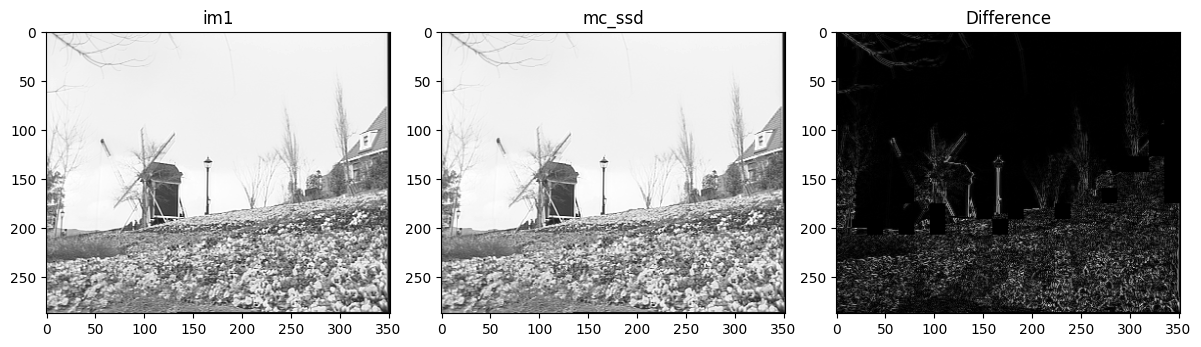

In [58]:
mc_ssd = fracMc(im1,mvf_ssd)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot im1
axs[0].imshow(im1, cmap='gray')
axs[0].set_title('im1')

# Plot mc_ssd
axs[1].imshow(mc_ssd, cmap='gray')
axs[1].set_title('mc_ssd')

# Plot the difference between im1 and mc_ssd
diff = im1 - mc_ssd
axs[2].imshow(abs(diff), cmap='gray')
axs[2].set_title('Difference')

plt.tight_layout()
plt.show()


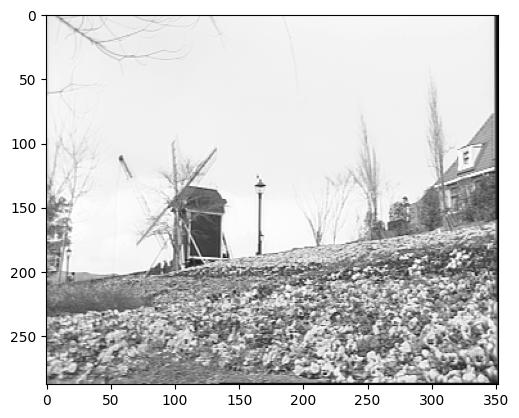

In [112]:
plt.imshow(mc_ssd, cmap='gray')


Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

PSNR, or Peak Signal-to-Noise Ratio, is a metric used to measure the quality of reconstruction, typically in image and signal processing. It compares the maximum possible power of a signal (the "peak" signal) to the power of corrupting noise that affects the fidelity of its representation.

$$PSNR = 20 \cdot \log_{10}(MAX_I) - 10 \cdot \log_{10}(MSE)$$

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

The PSNR  im1 and im2 is greater when compared to the im2 and motion-compensated images. It makes sense because im1 and im2 are very similar. The block matching process introduces innacuracies, related to the approximations, estimation errors, etc... 



In [90]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    
    
    psnr =  20 * np.log10(np.max(im1) / np.sqrt(np.mean((im1 - im2) ** 2)))
    return psnr

In [91]:

# Define the different block sizes and search radii to test
block_sizes = [8, 16, 32]
search_radii = [4, 8, 12, 16] 

# Iterate over the block sizes and search radii
for block_size in block_sizes:
    for search_radius in search_radii:
        # Call the me_ssd method with the current block size and search radius
        mvf_ssd, pred = me_ssd(im2, im1, block_size, block_size, search_radius)
        mc_ssdtemp = fracMc(im1,mvf_ssd)
        # Compute the PSNR for the current result
        psnr_ssd = PSNR(im2, mc_ssdtemp)
        
        # Print the PSNR value
        print(f"Block Size: {block_size}, Search Radius: {search_radius}, PSNR: {psnr_ssd} dB")
print(f'PSNR for im1 and im2 = {PSNR(im2, im1):.2f} dB')

Block Size: 8, Search Radius: 4, PSNR: 16.44312964795355 dB
Block Size: 8, Search Radius: 8, PSNR: 16.411388922595744 dB
Block Size: 8, Search Radius: 12, PSNR: 16.30802192915199 dB
Block Size: 8, Search Radius: 16, PSNR: 16.117943005723326 dB
Block Size: 16, Search Radius: 4, PSNR: 16.463010154010572 dB
Block Size: 16, Search Radius: 8, PSNR: 16.460076383673186 dB
Block Size: 16, Search Radius: 12, PSNR: 16.458918274136614 dB
Block Size: 16, Search Radius: 16, PSNR: 16.458704686485987 dB
Block Size: 32, Search Radius: 4, PSNR: 16.347557886411288 dB
Block Size: 32, Search Radius: 8, PSNR: 16.347554902995817 dB
Block Size: 32, Search Radius: 12, PSNR: 16.347552970880223 dB
Block Size: 32, Search Radius: 16, PSNR: 16.347552970880223 dB
PSNR for im1 and im2 = 18.79 dB


In [114]:

print(f'PSNR im1 and im2 = {PSNR(im2, im1):.2f} dB')
print(f'PSNR SSD = {PSNR(im2, mc_ssd):.2f} dB')


PSNR im1 and im2 = 18.79 dB
PSNR SSD = 16.35 dB


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [77]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%

def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+bcol]  # Block #####

                # Initialization:
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                best_drow, best_dcol = 0, 0

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns ####
                for dcol in range(-search, search+1):
                    for drow in range(-search, search+1):

                        temp_block = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]

                        temp_cost = np.sum(np.abs(B - temp_block))

                        if temp_cost < costMin:  # Save the results if they are better than the previous ones
                            costMin = temp_cost
                            Rbest = temp_block
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest
                
    else: # Regularized search
        print('Regularization')
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+bcol]  # Block #####

                # Initialization:
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                best_drow, best_dcol = 0, 0

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns #####
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                for dcol in range(-search, search+1):
                    for drow in range(-search, search+1):

                        temp_block = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]

                        temp_cost = np.sum(np.abs(B - temp_block)) + lamb * np.sum(np.abs(([drow, dcol] - pV)))

                        if temp_cost < costMin:  # Save the results if they are better than the previous ones
                            costMin = temp_cost
                            Rbest = temp_block
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [78]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.


For the unregularized version both are not that good, once there is the constant sky area. For the regularized, sad seems more robust, returning a more uniform MF.

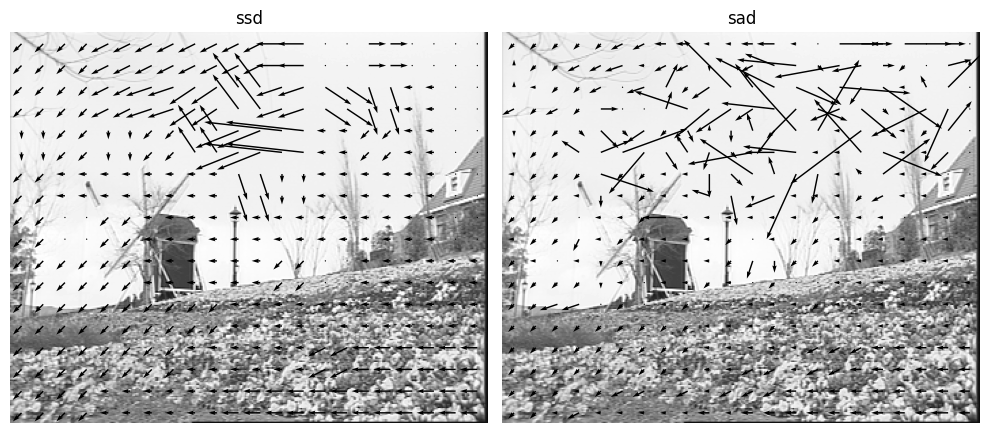

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

row, col = np.shape(im1)
for i in range(2):
	if i == 0:
		mvf = mvf_ssd
	else:
		mvf = mvf_sad

	vectRow = mvf[0:row:brow, 0:col:brow, 0]
	vectCol = mvf[0:row:brow, 0:col:brow, 1]

	# Determine vector origins
	X, Y = np.meshgrid(np.arange(0, im1.shape[1], brow), np.arange(0, im1.shape[0], brow))
	X = X + np.floor(brow / 2.)
	Y = Y + np.floor(brow / 2.)

	# Show image
	axs[i].imshow(im1, cmap='gray')

	axs[i].quiver(X, Y, vectCol, -vectRow)
	if i == 0:
		axs[i].set_title(f"ssd")
	else:
		axs[i].set_title(f"sad")
	axs[i].axis('off')

plt.tight_layout()
plt.show()

Regularization
Regularization


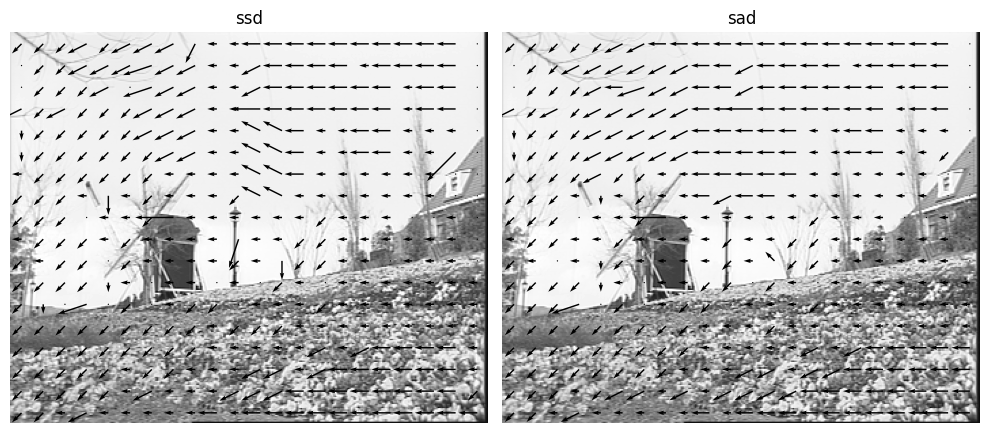

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

row, col = np.shape(im1)
mvf_sad, _ = me_sad(im2, im1, brow, bcol, search_radius, lamb=0.1)
mvf_ssd, _ = me_ssd(im2, im1, brow, bcol, search_radius, lamb=0.1)
for i in range(2):
	if i == 0:
		mvf = mvf_ssd
	else:
		mvf = mvf_sad

	vectRow = mvf[0:row:brow, 0:col:brow, 0]
	vectCol = mvf[0:row:brow, 0:col:brow, 1]

	# Determine vector origins
	X, Y = np.meshgrid(np.arange(0, im1.shape[1], brow), np.arange(0, im1.shape[0], brow))
	X = X + np.floor(brow / 2.)
	Y = Y + np.floor(brow / 2.)

	# Show image
	axs[i].imshow(im1, cmap='gray')

	axs[i].quiver(X, Y, vectCol, -vectRow)
	if i == 0:
		axs[i].set_title(f"ssd")
	else:
		axs[i].set_title(f"sad")
	axs[i].axis('off')

plt.tight_layout()
plt.show()

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

The PSNR is almost the same with SAD than it was with SSD.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

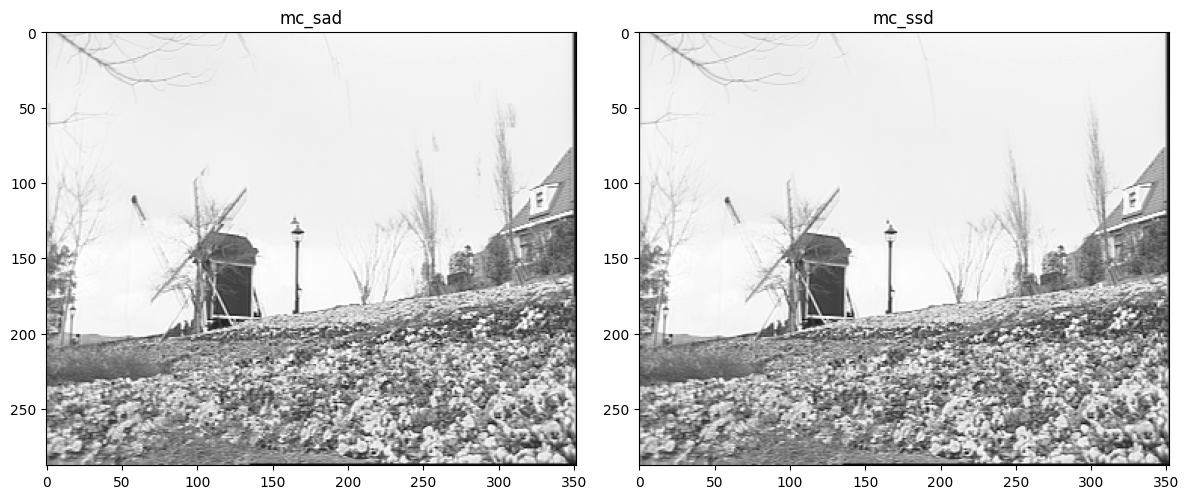

In [80]:
mc_sad = fracMc(im1, mvf_sad)
mc_ssd = fracMc(im1, mvf_ssd)

# Plot mc_sad
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mc_sad, cmap='gray')
plt.title('mc_sad')

# Plot mc_ssd
plt.subplot(1, 2, 2)
plt.imshow(mc_ssd, cmap='gray')
plt.title('mc_ssd')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


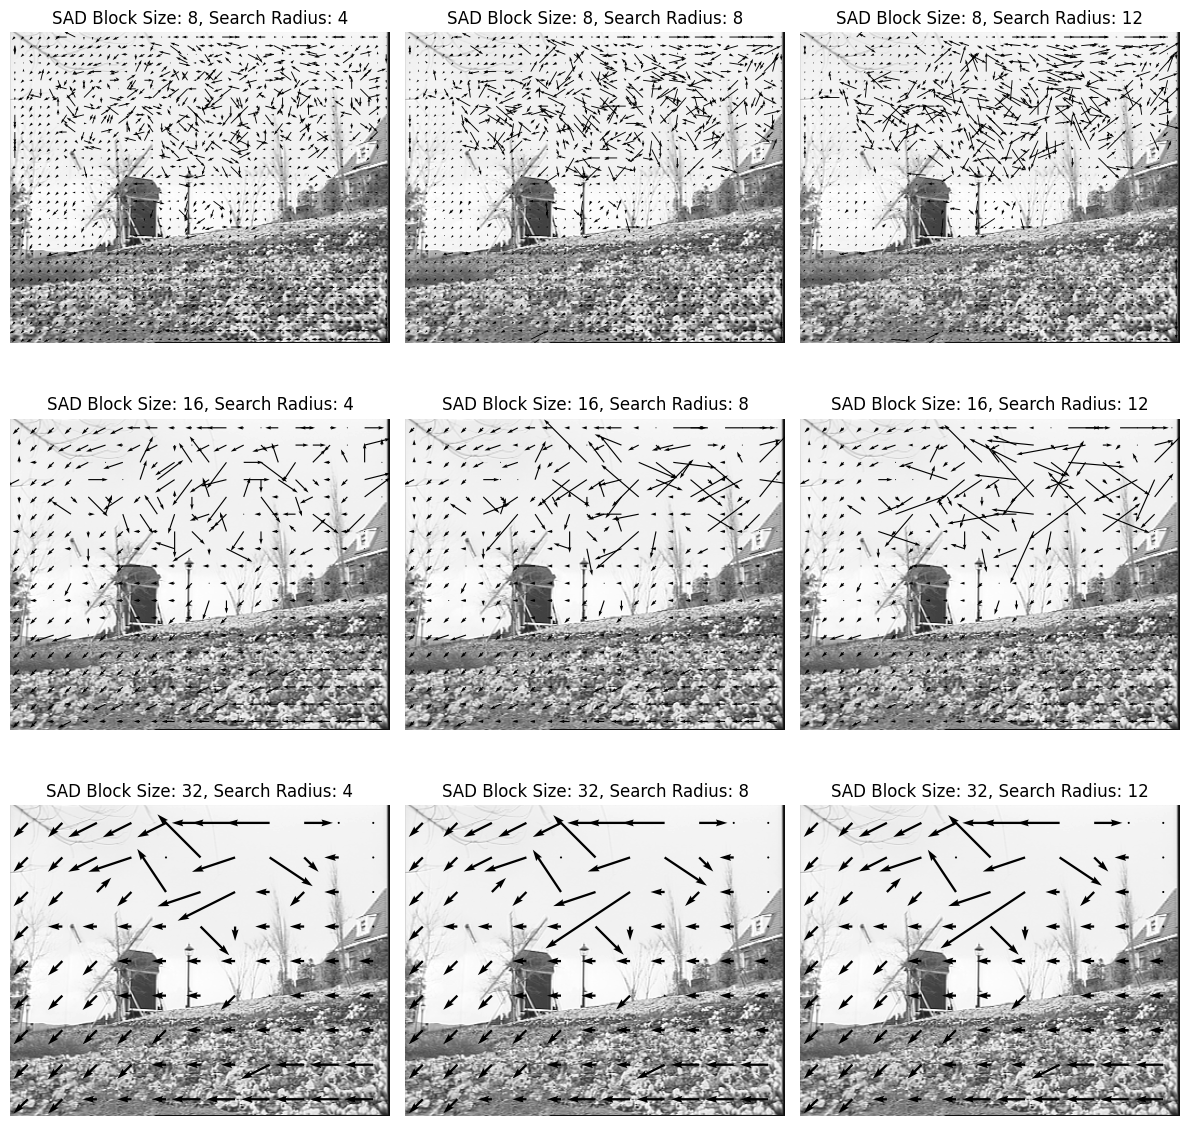

In [81]:
block_sizes = [8, 16, 32]  # List of block sizes to iterate over
search_radii = [4, 8, 12]  # List of search radii to iterate over

fig, axs = plt.subplots(len(block_sizes), len(search_radii), figsize=(12, 12))

row,col = np.shape(im1)
for i, block_size in enumerate(block_sizes):
	for j, search_radius in enumerate(search_radii):
		mvf, prediction = me_sad(im2, im1, block_size, block_size, search_radius)
		subsamp = 4  # Subsampling factor for dense MVF display

		vectRow = mvf[0:row:block_size, 0:col:block_size, 0]
		vectCol = mvf[0:row:block_size, 0:col:block_size, 1]

		# Determine vector origins
		X, Y = np.meshgrid(np.arange(0, im1.shape[1], block_size), np.arange(0, im1.shape[0], block_size))
		X = X + np.floor(block_size / 2.)
		Y = Y + np.floor(block_size / 2.)

		# Show image
		axs[i, j].imshow(im1, cmap='gray')

		axs[i, j].quiver(X, Y, vectCol, -vectRow)
		axs[i, j].set_title(f"SAD Block Size: {block_size}, Search Radius: {search_radius}")
		axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [92]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

16.398883709134125


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

Regularization
Regularization
Regularization
Regularization
Regularization
Regularization
Regularization
Regularization
Regularization


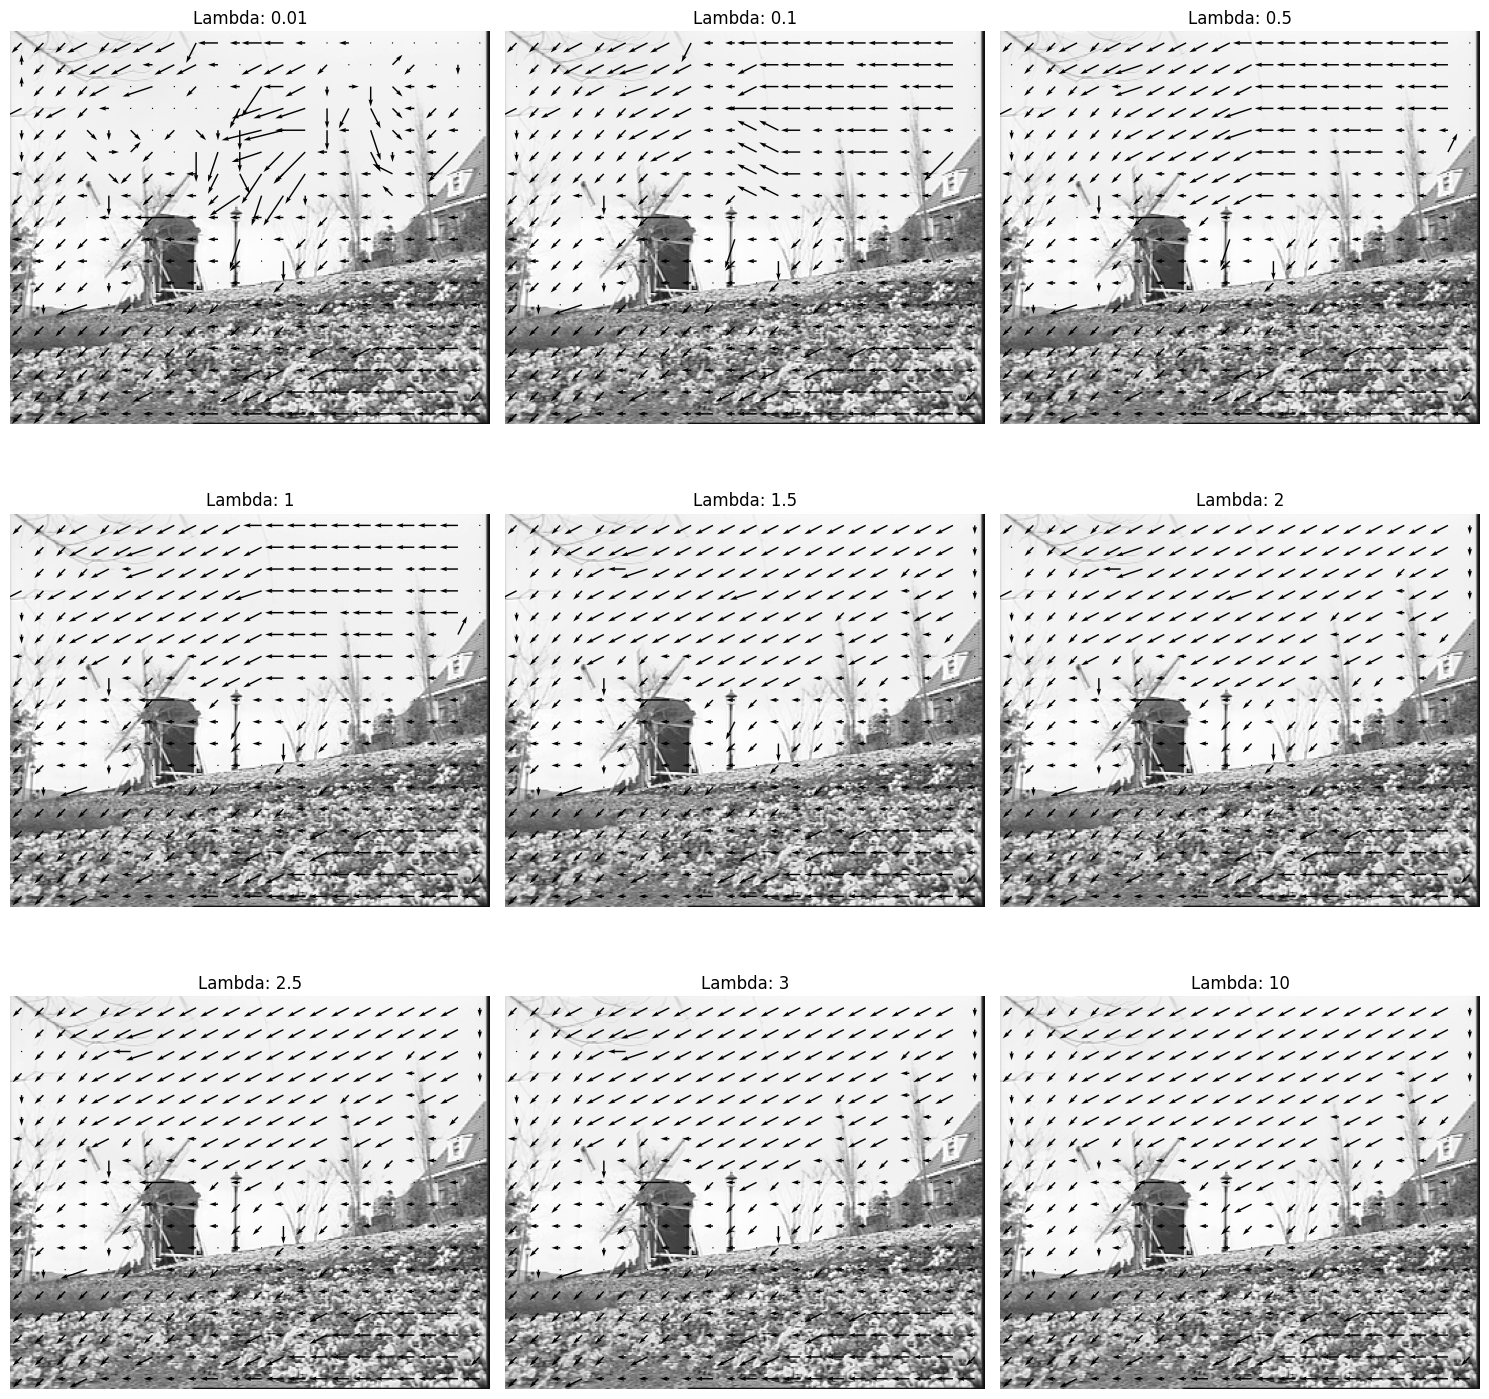

In [121]:
lambda_possible_values = [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 10]
fig, axs = plt.subplots(len(lambda_possible_values)//3, 3, figsize=(15, 15))

brow = 16
bcol = 16
search_radius = 8

row, col = np.shape(im1)
mvf_ssds = []
for i, lamb in enumerate(lambda_possible_values):
	mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb)
	mvf_ssds.append(mvf_ssd)
	vectRow = mvf_ssd[0:row:brow, 0:col:brow, 0]
	vectCol = mvf_ssd[0:row:brow, 0:col:brow, 1]

	# Determine vector origins
	X, Y = np.meshgrid(np.arange(0, im1.shape[1], brow), np.arange(0, im1.shape[0], brow))
	X = X + np.floor(brow / 2.)
	Y = Y + np.floor(brow / 2.)

	# Show image
	axs[i // 3, i % 3].imshow(im1, cmap='gray')
	axs[i // 3, i % 3].quiver(X, Y, vectCol, -vectRow)
	axs[i // 3, i % 3].set_title(f"Lambda: {lamb}")
	axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()


### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

Regularization
Regularization
Regularization
Regularization
Regularization
Regularization
Regularization
Regularization
Regularization


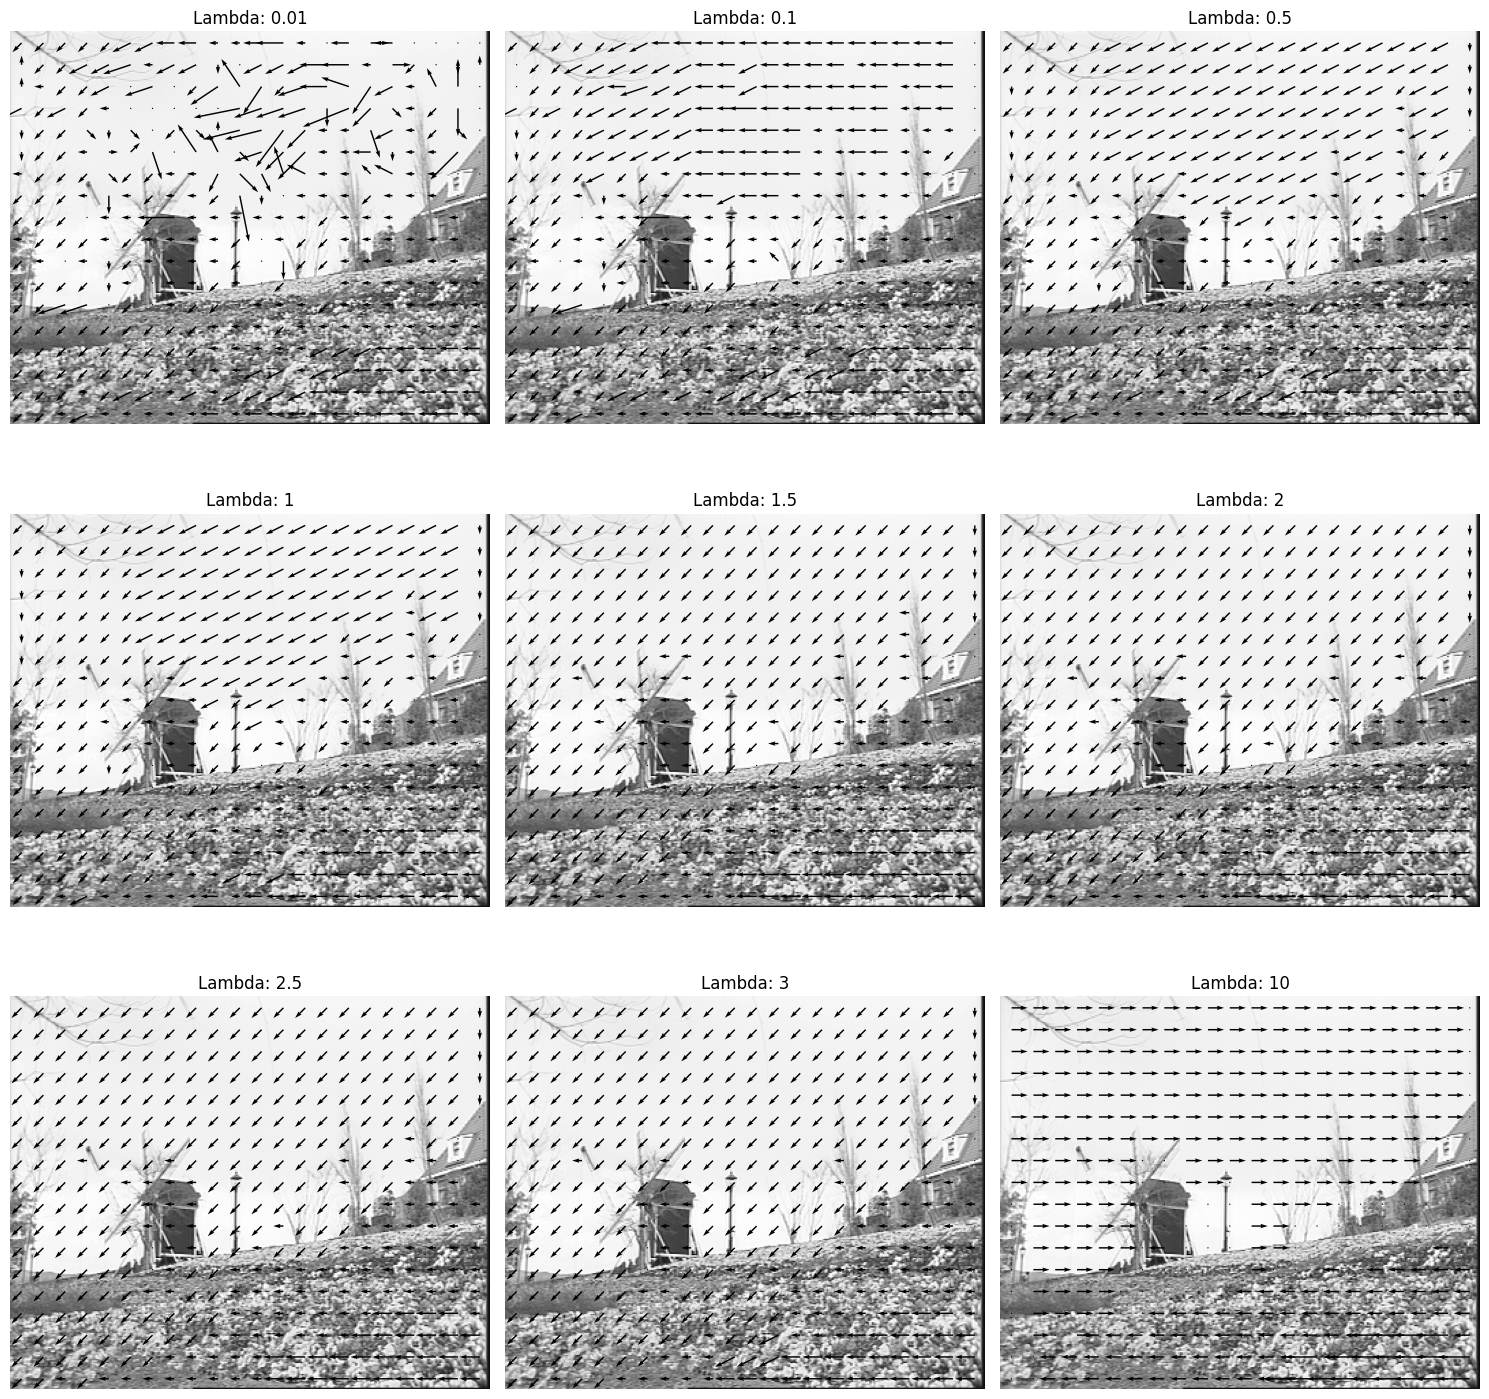

In [122]:
lambda_possible_values = [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 10]
fig, axs = plt.subplots(len(lambda_possible_values)//3, 3, figsize=(15, 15))

row, col = np.shape(im1)
mvf_sads = []
for i, lamb in enumerate(lambda_possible_values):
	mvf_sad, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb)
	mvf_sads.append(mvf_sad)
	vectRow = mvf_sad[0:row:brow, 0:col:brow, 0]
	vectCol = mvf_sad[0:row:brow, 0:col:brow, 1]

	# Determine vector origins
	X, Y = np.meshgrid(np.arange(0, im1.shape[1], brow), np.arange(0, im1.shape[0], brow))
	X = X + np.floor(brow / 2.)
	Y = Y + np.floor(brow / 2.)

	# Show image
	axs[i // 3, i % 3].imshow(im1, cmap='gray')
	axs[i // 3, i % 3].quiver(X, Y, vectCol, -vectRow)
	axs[i // 3, i % 3].set_title(f"Lambda: {lamb}")
	axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()


For each block in the current image, the function computes a predictor vector pV using the ```computePredictor``` function, which computes the median of motion vectors from neighboring blocks.
Throughout the motion estimation procedure, the function evaluates the resemblance between the present block and potential blocks within the reference frame, as well as the discrepancy between the proposed motion vector and the anticipated motion vector.

For both of them, if lambda is too small, we can see the problem in the sky, once the regularization parameter is too small, it almost doesn't change anything. If the regularization term is too high we cannot see relevant information, because MVF is too much homogeneous.

Given the same lamb value, the regularization term carries more influence in SAD compared to SSD. This is because the data-attachment term in SSD is relatively larger when compared to the data-attachment term in SAD.

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [93]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

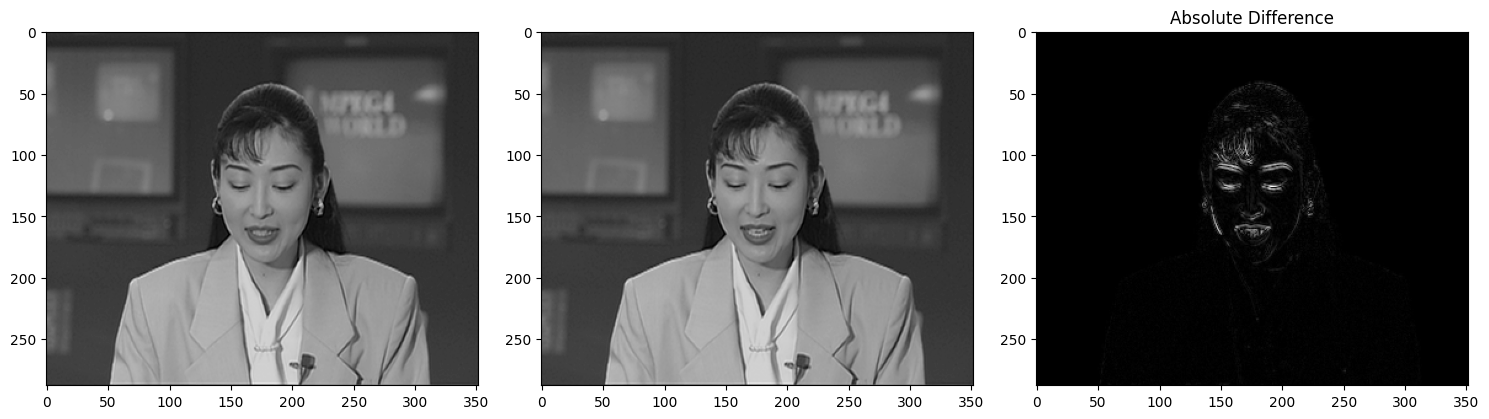

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot im1
axs[0].imshow(im1, cmap='gray')

# Plot im2
axs[1].imshow(im2, cmap='gray')

# Plot absolute difference
diff = np.abs(im2 - im1)
axs[2].imshow(diff, cmap='gray')
axs[2].set_title('Absolute Difference')

plt.tight_layout()
plt.show()


Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

Regularization


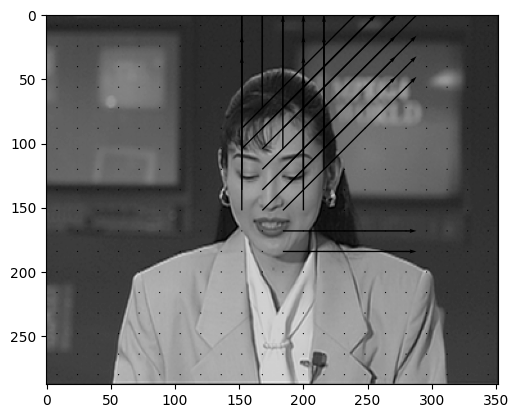

In [102]:
brow = 16; bcol=16; search_radius =13;

mvf, _ = me_sad(im2, im1, brow, bcol, search_radius, lamb=0.1)

displayMVF(im1, mvf, brow)

In [97]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=  convolve2d(u, kernel_1, 'same')
        vAvg =  convolve2d(v, kernel_1, 'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - (fx * (fx * uAvg + fy * vAvg + ft)) / (alpha**2 + fx**2 + fy**2)
        v = vAvg - (fy * (fx * uAvg + fy * vAvg + ft)) / (alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [103]:
alpha = 100
ite = 100

uInitial = mvf_sad[:, :, 1]
vInitial = mvf_sad[:, :, 0]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.


We can see great improvemments in Akijo image. The image's background displays a steady Motion Vector Field (MVF) of zero, which is accurate as the newscaster's face is the sole moving element. A significant amount of detail is observable in the facial area, aligning with the frame movements. 

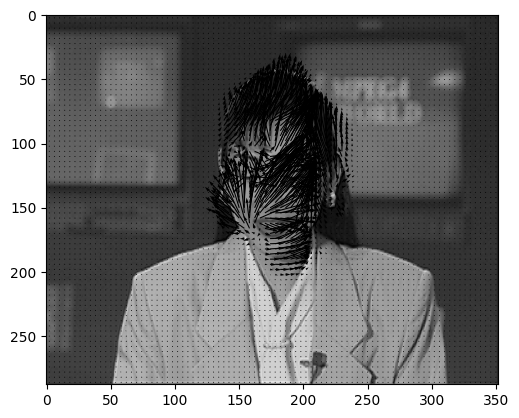

In [108]:
mvf_hs = np.zeros((np.shape(v)[0], np.shape(v)[1], 2))
mvf_hs[:, :, 0] = v
mvf_hs[:, :, 1] = u

displayMVF(im1, mvf_hs, 4)

PSNR HS = 35.744988883761074 dB
None


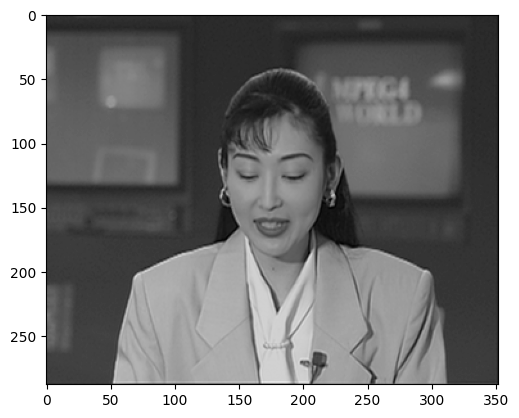

In [110]:
mc_hs = fracMc(im1, mvf_hs)

print(print(f'PSNR HS = {PSNR(im2, mc_hs)} dB'))

plt.figure()
plt.imshow(mc_hs, cmap='gray')
plt.show()

Regularization
PSNR HS = 20.73 dB


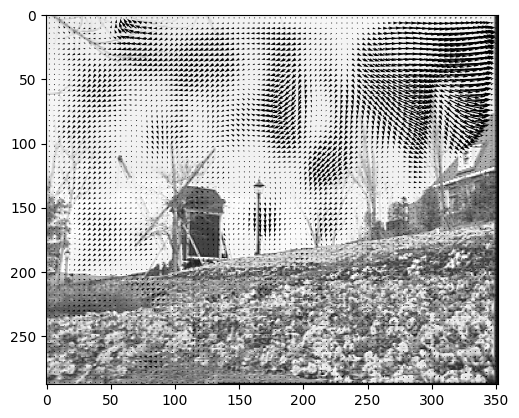

In [118]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

alpha = 100
ite = 100

mvf, _ = me_sad(im2, im1, brow, bcol, search_radius, lamb=0.1)

# Rem: pay attention to the inversion of the order compare to me_ssd.
uInitial = mvf[:, :, 1]
vInitial = mvf[:, :, 0]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite, blur=1.)

mvf_hs = np.zeros((np.shape(v)[0], np.shape(v)[1], 2))
mvf_hs[:, :, 0] = v
mvf_hs[:, :, 1] = u

displayMVF(im1, mvf_hs, 4)

mc_hs = fracMc(im1, mvf_hs)
psnr_hs = PSNR(im2, mc_hs)
print(f'PSNR HS = {psnr_hs:.2f} dB')

For the flowers image seems much better. Despite the sky's vectors are not null, they are much smaller.

In both cases the PSNR has increased.